In [285]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import random as rng
%matplotlib inline

In [286]:
# Modeling queen egg laying behavior

# Egg laying of a queen is dependent on adult working population, day-length, resource influx, and ambient temperature

## This seasonal profile season(t) is perhaps an oversimplification of the weather and we can try to complicate it 

def season(t):
    '''
    Function to define a seasonal factor as a function of t, in days. It influences daily egg laying rate of queen,
    and nectar and pollen availability in the environment
    
    Args:
        t: (int) day number. Measured since as # since Jan 1st
        xi:    (floats)    Parameters that influence the shape of the season factor and can be adjusted to adjust for different climates

    Out:
        seasonValue:    (float) the season factor function at time t
    
    '''
    poss1 = 1 - (1/(1+x1*np.exp(-2*t/x2)))
    poss2 = (1/(1+x3*np.exp(-2*(t-x4)/x5)))
    seasonValue = np.maximum(poss1,poss2)
    return seasonValue

# HoPoMo includes a suppression factor SUPcomb(t) to describe suppression in egg laying when available empty space in the 
#  hive is below the threshold parameter SUPthreshold 
# The gradual lowering off egg laying rate is interpreted as the increased searching time for an empty cell 
# To calculate ratio of available empty cells to total cells, they defined a constant CELLShive as the total number of cells in a hive

# Since we will likely only be interested in modeling 10 frame brood boxes, we will likely avoid implementing SUPcomb(t)

# Empty cell threshold determines after which egg laying rate declines
SUPthreshold = .2

# Constants representing number of cells in frames and hive
CELLSperframe = 9000
FRAMESperhive = 10
CELLShive = CELLSperframe*FRAMESperhive

def CELLSempty(t):
    value = CELLShive - CELLSbrood(t)-STORESpollen(t)-STORESnectar(t)-STOREShoney(t)
    return value

def SUPcomb(t):
    if (CELLSempty(t)/(CELLShive+1))<SUPthreshold:
        value = CELLSempty(t)/((CELLShive+1)*SUPthreshold)
    else:
        value = 1
    return value

# To account for variability in Queen laying rates even with available cells, implemented a stochastic factor ELRstoch(t)
# ELRstoch is assumed to be uniformaly distributed around 0 from -ERLstochrange to +ERLstochrange

ERLstochrange = .01

# ELRbase is the mean daily egg laying rate of the queen at the maximum egg laying peak in Spring
# Queen also differ individually in max egg laying capacity, so this is also a genetic factor
# Additionally, this base number can be used to model queen age
ELRbase = 1000.

def ELRstoch(t):
    return rng.uniform(-ERLstochrange, ERLstochrange)
    
def ELR(t):
    '''
    Function to model the daily laying rate of a queen
    
    Args:
        t: (int) day number. Measured since as # since Jan 1st

    Out:
        layRate:    (float) the laying rate for a queen on a given day
    '''
    layRate = ELRbase * (1 + ELRstoch(t))*(1-season(t))*SUPcomb(t)
    return layRate

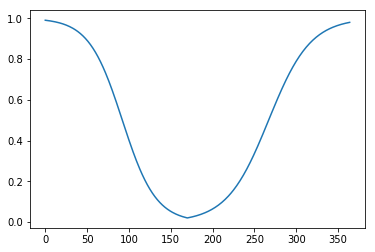

In [287]:
# Testing season(t)
x1 = 100
x2 = 40
x3 = 800
x4 = 100
x5 = 50
year = np.arange(365)
plt.plot(year, season(year))

In [288]:
# Modeling brood development

# Constants that stand for the development period for 
LIFESPANegg = 3
LIFESPANlarvae = 5
LIFESPANpupa = 12

# Constants that represent the initial population state of the colony
INITeggs = np.zeros(LIFESPANegg)
INITlarvae = np.zeros(LIFESPANlarvae)
INITpupae = np.zeros(LIFESPANpupa)


# Daily egg mortality, treated as a constant in this model
MORTALITYeggs = .03

# Model for the amount of brood at each day t, where i indicates the age of the immature individual, in days

def EGGS(i, t):
    if t==0:
        return INITeggs[i-1]
    if t<=0:
        print('This should not have been called')
        return None
    if i ==1:
        value = ELR(t-1)*(1-MORTALITYeggs)
    elif (i==2 or i==3):
        value = EGGS(i-1, t-1)*(1-MORTALITYeggs)
    elif i>3:
        print('These are no longer eggs. It should have called the Larvae function')
        return None
    return value

# Time independent base mortality of larvae
MORTALITYlarvae = .01

# Rate of cannibalism of larvae depends on size of nurse population, pollen status of the colony, and age specific canabalism rate (CANNIBALISMhungerbase(i))
def CANNIBALISMlarvae(i,t):
    if t==0:
        return 0.
    else:
        value = CANNIBALISMhungerbase(i)*(1-(INDEXpollensituation(t-1)*INDEXnursingquality(t-1)))
        return value

# A constant representing base cannibalism rates dependent on age
CANNIBALISMhungerbasevar = [.23,.3,.58,.06,0]
def CANNIBALISMhungerbase(i):
    if i == 1:
        return CANNIBALISMhungerbasevar[0]
    if i == 2:
        return CANNIBALISMhungerbasevar[1]
    if i == 3:
        return CANNIBALISMhungerbasevar[2]
    if i == 4:
        return CANNIBALISMhungerbasevar[3]
    if i == 5:
        return CANNIBALISMhungerbasevar[4]

# Rate of survival of larvae depends on cannibalism rate and base survival rate 
def SURVIVALlarvae(i,t):
    value = (1-CANNIBALISMlarvae(i,t))*(1-MORTALITYlarvae)
    return value
        
def LARVAE(i,t):
    if t==0:
        return INITlarvae[i-1]
    if i ==1:
        value = EGGS(LIFESPANegg, t-1)*SURVIVALlarvae(1,t)    
    elif i<=LIFESPANlarva:
        value = LARVAE(i-1,t-1)*SURVIVALlarvae(i,t)
    elif i>LIFESPANlarva:
        print('These are no longer larva. It should have called the Pupae function')
        return None
    return value

# Mortality rate of pupae, treated as a constant here, and it is usually signicantly smaller than that for eggs or larvas
MORTALITYpupae = .001

# Calculates the age demography of all sealed brood, treating the first day after a cell being sealed as the same as the actual pupae stage
# All sealed brood does not require feeding from nurse bees, which is why we group it all as pupae
def PUPAE(i,t):
    if t==0:
        return INITpupae[i-1]
    if i == 1:
        value = LARVAE(LIFESPANlarva, t-1)*(1-MORTALITYpupae)
    elif i<=LIFESPANlarva:
        value = PUPAE(i-1,t-1)*(1-MORTALITYpupae)
    elif i>LIFESPANlarva:
        print('These are no longer Pupae. It should have called the bee function')
        return None
    return None
    
# Function that returns the number of cells that have eggs
# The number of 1-day-old eggs is derived from the egg laying rate on the previous day (ELR(t-1)). 
# The number of 2- or 3-day-old eggs is derived from the number of eggs 1 day younger on the previous day (EGGS(i-1,t-1))
def CELLSeggs(t):
    value = 0
    for i in range(LIFESPANegg):
        # The +1 is to make i represent the age of the growing bees 
        value += EGGS(i+1,t)
    return value

# Function that returns the number of cells that have unsealed larvae
def CELLSlarvae(t):
    value = 0
    for i in range(LIFESPANlarva):
        # The +1 is to make i represent the age of the growing bees 
        value += LARVAE(i+1,t)
    return value


# Function that returns the number of cells that have sealed brood
def CELLSpupae(t):
    value = 0
    for i in range(LIFESPANpupa):
        # The +1 is to make i represent the age of the growing bees 
        value +=PUPAE(i+1,t)
    return value

# Total number of cells with brood
def CELLSbrood(t):
    value = CELLSeggs(t)+CELLSlarvae(t)+CELLSpupae(t)
    return value


In [289]:
# Modeling adult bee population


# Returns the overall daily mortality rate of the adult bee population based on a constant mortality rate, as well as task specific mortality rates

# We use the numbers of bees on the previous day (t-1) in to prevent a circular formula definition with BEESadult(t)
# MORTALITYforaging is a constant factor because the influence of environmental conditions on forager mortality is baked into 
# the calculation of FORAGERSactive(t). Considers environmental conditions (temperature, rain and environmental resource availability)
# as well as the internal status of the colony (demand, foraging workforce, processing workforce) affect the size of
# FORAGERSactive(t) and thus affect automatically the fraction of foraging-caused mortality within the overall adult mortality.

def MORTALITYadult(t):
    # Contribution to total population mortality is weighted by portion of bees performing the task on a given day
    if t==0:
        value = MORTALITYadultbase
        return value
    else:
        NURSErate = MORTALITYnursing*(NURSES(t-1)/(BEESadult(t-1)+1)) 
        PROCESSORrate = MORTALITYprocessing*(PROCESSORS(t-1)/(BEESadult(t-1)+1))
        FORAGERrate = MORTALITYforaging*(FORAGERSactive(t-1)/(BEESadult(t-1)+1))
        value = MORTALITYadultbase + NURSErate + PROCESSORrate + FORAGERrate
        return value

# Constant mortality rates for adult bees, and task specific mortality rate
MORTALITYadultbase = .01
MORTALITYnursing = .005
MORTALITYprocessing = .005
MORTALITYforaging = .035

# Initial size of adult bee population
INITadult = 1000

# Returns the number of adult bees on a given day, based on the number newly hatched adult bees and the survival of adult bees from the previous day
def BEESadult(t):
    if t == 0:
        return INITadult
    else:
        value = (BEESadult(t-1) + PUPAE(LIFESPANpupa, t-1))*(1 - MORTALITYadult(t))
        return value


In [290]:
# Modeling environmental influence

# Time dependent parameter that takes a value between 0 and 1 to determine effects of rain on colony foraging activities on day t
# 1: rain had no effect on foraging activity on day t
# 0: rain prevented any foraging on day t
# .5: foraging happened for only half of the day
def INDEXrain(t):
    value = 1-RAIN[t]
    return value

HOURSrainingDuringDaylight = np.zeros(366)
HOURSdaylight = [8 for i in range(len(HOURSrainingDuringDaylight))]
# Expresses rainy hours of a day as a fraction of all daylight hours in that day. Daylight hours represent all possible foraging hours.
# For real hourly weather data, this value represents the average rain value over a given day 
RAIN = HOURSrainingDuringDaylight/HOURSdaylight



#HOURSrainingDuringDaylight, HOURSdaylight are arrays of equal length

# Models the influence of outside temperature on the bees’ flight activity, based on research by Szabo in 1980
# Temp(t) is the mean value of temperature in celcius calculated between 8:00am and 10:00pm
# Assumes no flights below 14C or above 40C, a linear increase of flight activity between 14 and 22C, optimal flight conditions 
#  between 22 and 32C, and a linear decrease in flight activity between 32 and 40C
# 1: temperature allows full foraging activity on day t
# 0: temperature prevents any foraging on day t
# .5: foraging happened for only half of the day

def INDEXtemperature(t):
    if TEMP(t)<=14:
        value = 0
    elif (TEMP(t)>14 & TEMP(t)<=22):
        value = (TEMP(t)-14)/8
    elif (TEMP(t)>22 & TEMP(t)<=32):
        value = 1
    elif (TEMP(t)>32 & TEMP(t)<=40):
        value = (40-TEMP(t))/8
    elif (TEMP(t)>40):
        value = 0
    return value

# Expresses the overall flight weather quality for, based on environmental factors, with a value between 0 and 1
# 1: Perfect flight conditions for the bees
# 0: Worst possible flight conditions
def INDEXflight(t):
    value = INDEXrain(t)*INDEXtemperature(t)
    return value


# Botanical resource supply (nectar, pollen) are also key environmental factors determining colony activity
# Since we lack information on how botanical resources affect foraging activity or method to empirically measure botanical resource supply available to real hives,
#  we use the seasonal factor to model these supplies

# The functions are constructed to return maximum food availibility (nectaroutside=pollenoutside=1) from April to July after which food supply diminshes day by day
def INDEXnectaroutside(t):
    value1 = (1 - season(t))*1.5
    if value1<1.:
        return value1
    else:
        return 1.
    
def INDEXpollenoutside(t):
    value1 = (1 - season(t))*1.5
    if value1<1.:
        return value1
    else:
        return 1.

In [291]:
# Modeling task decision-making

# This model assumes that brood nursing and pollen foraging are the two highest priority tasks of the colony
# Therefore, we first find the total workload for those two tasks, and assign bees to fulfill that workload, if enough exist
# Remaining bees can then potentially be involved in nectar focused tasks

# Determines the total need for workers for the two highest priority tasks on day t
def NEEDworkers(t):
    value = NEEDnurses(t) + NEEDpollenforagers(t)
    return value

# Accounts for fraction of adult bee population engaged in tasks not modeled, such as guarding, cleaning, etc.
FACTORothertasks = .2

# Calculates ratio of available workforce to workload on day t
# RATIOworkforce(t)<1, then there is a fraction of the needed work that will not be completed on day t
def RATIOworkforce(t):
    value1 = (BEESadult(t)*(1 - FACTORothertasks))/(NEEDworkers(t)+1)
    if value1<1.:
        return value1
    else:
        return 1.


In [292]:
# Modeling the regulation of nursing

# We assume that the nursing requirement per egg and per pupa are constants that do not depend on the age of the egg or pupa
# Since larvae and their consumption grow exponentially, we model the nursing requirement for larva in 1 day age classes

def NEEDnurses(t):
    value = 0
    for i in range(LIFESPANlarva):
        value+= LARVAE(i+1, t)*NEEDnurses_per_larva[i]
    value+= CELLSeggs(t)*NEEDnurses_per_egg + CELLSpupae(t)*NEEDnurses_per_pupa
    return value


NEEDnurses_per_egg = .33
NEEDnurses_per_pupa = .33
NEEDnurses_per_larva = [.1,.5,.75,1.75,3]

# Returns the total number of active nurse bees on day t, assuming RATIOworkforce of the need is met up to  
def NURSES(t):
    value = NEEDnurses(t)*RATIOworkforce(t)
    return value

# Value used to model important feedback loop based on meeting nursing needs
def INDEXnursingquality(t):
    value = NURSES(t)/(NEEDnurses(t)+1)
    return value

In [325]:
# Modeling the regulation of foraging

# Models total daily available foraging workforce
def FORAGERS(t):
    value = FORAGERSpollen(t)+FORAGERSnectar(t)
    return value

# Calculates the actual number of foragers that fly out on day t, which is dependednt on weather botanical resource factors
def FORAGERSactive(t):
    value = FORAGERSpollenactive(t) + FORAGERSnectaractive(t)
    return value

# Pollen foraging is regulated by the current pollen demand, and nurse bees and brood are the chief consumers of pollen

def NEEDpollen(t):
    if t<0:
        print('I should not have been called')
    print(t)
    value = NEEDpollen_larvae(t)+NEEDpollen_adult(t)
    return value

# Pollen demand of larvae is calculated by summing over the age depended of pollen demand per larva
def NEEDpollen_larvae(t):
    value = 0
    for i in range(LIFESPANlarva):
        value+= POLLENNEEDlarva[i]*LARVAE(i+1,t)
    return value

# Pollen demand of adults is calculated by adding pollen demand of adults and additional pollen demand of nurses, both considered constants
POLLENNEEDadult = .0065
POLLENNEEDnurse = .00087
POLLENNEEDlarva = [.001,.003 , .006, .012, .027]

def NEEDpollen_adult(t):
    value = BEESadult(t)*POLLENNEEDadult + NURSES(t)*POLLENNEEDnurse
    return value

# Constant that represents the storage level of pollen maintained by a hive
# A value of 3 means that the hive stores enough pollen to last about 3 days, based on current levels of demand
# This constant value represents genetic variation
FACTORpollenstorage = 6

# Calculated the daily need for pollen income based on pollen need, current pollen stores, and desired storage level
def NEEDpollenincome(t):
    avgNeed = 0
    if t == 0:
        avgNeed = 0
    elif t<3:
        avgNeed = NEEDpollen(t)
    else:
        for d in range(3):
            avgNeed+=NEEDpollen(t-d)
        avgNeed = avgNeed/3
    value = avgNeed*FACTORpollenstorage - STORESpollen(t)
    if value>0.:
        return value
    else:
        return 0.
    
# The amount of pollen collected in foraging trip, in units of cellfulls
LOADpollenforager = .06

# The number of trips made in a day by a pollen forager
TURNSpollenforager = 20

def NEEDpollenforagers(t):
    if t==0:
        value = NEEDpollenincome(0)/ (LOADpollenforager*TURNSpollenforager*FACTORforagingsuccess)
        return value
    else:
        value = NEEDpollenincome(t-1)/ (LOADpollenforager*TURNSpollenforager*FACTORforagingsuccess)
        return value

# Sets limit on the ratio of total foragers on a given day
FACTORforagingmax = .33

# Expresses the overall success rate of faraging trips
FACTORforagingsuccess = .8

# Corrects for fact that, regardless of pollen need, there is some minimum number of pollen foragers in a cohort of bees
FACTORminpollenforagers = .01

# Models potential number of pollen foragers on day t based on need for additional pollen
# Preferentially selects pollen foragers over nectar foragers, increasing their ratio without increasing number of foragers
def FORAGERSpollen(t):
    value1 = NEEDpollenforagers(t)*RATIOworkforce(t)
    valueMin = (BEESadult(t)-NURSES(t))*FACTORminpollenforagers
    value = np.max((value1,valueMin))
    valueMax = BEESadult(t)*FACTORforagingmax
    valueTrue = np.min((value,valueMax))
    return valueTrue

# Models number of active pollen foragers based on environmental conditions
def FORAGERSpollenactive(t):
    value= FORAGERpollen(t)*INDEXflight(t)*INDEXpollenoutside(t)
    return value

In [326]:
# Modeling nectar foraging

def NEEDnectar(t):
    value = NEEDnectar_larvae(t) + NEEDnectar_adult(t)
    return value

# Nectar demand of larvae is calculated by summing over the age depended of nectar demand per larva
def NEEDnectar_larvae(t):
    value = 0
    for i in range(LIFESPANlarva):
        value+= NECTARNEEDlarva[i]*LARVAE(i+1,t)
    return value

# Pollen demand of adults is calculated by adding pollen demand of adults and additional pollen demand of both nurses, considered constants
NECTARNEEDadult = .1
NECTARNEEDnurse = .2
NECTARNEEDlarva = [.006,.018,.04,.09,.185]

def NEEDnectar_adult(t):
    value = BEESadult(t)*NECTARNEEDadult + NURSES(t)*NECTARNEEDnurse
    return value

# Since nectar is collected in excess when possible, we assign all available foraging bees not collecting pollen to nectar related tasks
# We also ensure only nectar foraging only occurs when the two high priority tasks are being fulfilled

# Calculates total available number of adult bees not involved in other tasks and are available for nectar related tasks
def WORKFORCEnectar(t):
    if RATIOworkforce(t) == 1:
        value = (BEESadult(t)*(1-FACTORothertasks))- NURSES(t)- FORAGERSpollen(t)
    else:
        value = 0
    return value

# Total number of potential nectar foragers, considering the fraction of nectar workforce that is already involved in processing 
def FORAGERSnectar(t):
    value1 = (BEESadult(t)*FACTORforagingmax)-FORAGERSpollen(t)
    value2 = WORKFORCEnectar(t)-PROCESSORS(t)
    value = np.min((value1,value2))
    return value

# Calculates number of active nectar foragers based on environmental conditions
def FORAGERSnectaractive(t):
    value = FORAGERSnectar(t)*INDEXflight(t)*INDEXnectaroutside(t)
    return value

In [327]:
# Modeling resource influx into a hive

# Projects the daily influx of nectar, making sure that it's not greater than total available cell space
def INCOMEnectar(t):
    if t==0:
        value1 = FORAGERSnectaractive(t)*LOADnectarforager*TURNSnectarforager*FACTORforagingstoch(t)*FACTORforagingsuccess
        return value1
    else:
        value1 = FORAGERSnectaractive(t)*LOADnectarforager*TURNSnectarforager*FACTORforagingstoch(t)*FACTORforagingsuccess
        value2 = CELLSempty(t-1)
        value = np.min((value1,value2))
        return value

# The amount of nectar collected in foraging trip, in units of cellfulls
LOADnectarforager = .04

# Number of trips made by a nectar forager
TURNSnectarforager = 10

# Projects the daily influx of pollen. Since the daily collection of pollen is small relative to that of nectar, we do are not concerned about going over capacity
def INCOMEpollen(t):
    value = FORAGERSpollenactive(t)*LOADpollenforager*TURNSpollenforager*FACTORforagingstoch(t)*FACTORforagingsuccess
    return value

# Time dependent stochastic factor associated with the success of foraging that varies symmetrically about 1
# Expresses daily fluctuations that smooth out over a long enough time scale
def FACTORforagingstoch(t):
    value = rng.uniform(-.75, 1.25)
    return value

# Describes the level of pollen stores relative to the demand situation of the colony
# This index is influences cannibalism and consumption rates
def INDEXpollensituation(t):
    value = STORESpollen(t)/(NEEDpollen(t)*FACTORpollenstorage+1)
    if value<1.:
        return value
    else:
        return 1.
    




In [328]:
# Modeling food regulation 

# Food processing bees are need to process collected nectar into honey

# In reality, the balancing of nectar processing and nectar foraging is based in the queing times of nectar foraging bees
#  to model that behavior on a day timesclae, we have simplified the mechanism, saying that the amount of nectar foraging is
#  dependent on the nectar stores of the previous day

# The number of processing bees required to process and store a cell of nectar
ProcessorsPerCell = 2

# Determines the daily number of bees needed to processes the nectar, based on the previous day's stores
def NEEDprocessors(t):
    if t==0:
        value = STOREnectar(0)*ProcessorsPerCell
        return value
    else:
        value = STOREnectar(t-1)*ProcessorsPerCell
        return value

# Determines the number of processor bees on day t, based upon need and avaialable nectar workforce
def PROCESSORS(t):
    value1 = NEEDprocessors(t)
    value2 = WORKFORCEnectar(t)
    value = np.min((value1,value2))
    return value

# Calculates the amount of processed nectar on day t, with a max value of represented by total nectar on a given day
def PROCESSEDnectar(t):
    if t==0:
        value1 = STORESnectar(0)-USAGEnectar(t)
        value2 = PROCESSORS(t)/ProcessorsPerCell
        value = np.min((value1,value2))
        return value
    else:
        value1 = STORESnectar(t-1)-USAGEnectar(t)
        value2 = PROCESSORS(t)/ProcessorsPerCell
        value = np.min((value1,value2))
        return value


In [329]:
# Modeling nutrient management


# Physiological component of a hive that represents the maximum fraction of pollen that can be saved by a hive through reducing consumption rate
FACTORpollensavingmax = .3

# Calculates the pollen usage (consumption) on day t by the colony, based on the the available pollen need and the current pollen situation 
def USAGEpollen(t):
    if t==0:
        value1= STORESpollen(t)
        value2 = NEEDpollen(0)* (1-(FACTORpollensavingmax * (1- INDEXpollensituation(0))))
        value = np.min((value1,value2))
        return value
    else:
        value1= STORESpollen(t)
        value2 = NEEDpollen(t-1)* (1-(FACTORpollensavingmax * (1- INDEXpollensituation(t-1))))
        value = np.min((value1,value2))
        return value

# Number of cells with pollen at t=0
INITpollen = 0
INITnectar = 0
INIThoney = 0

# Calculates the daily amount of stored pollen
def STORESpollen(t):
    if t==0:
        value = INITpollen
        return value
    else:
        value = STORESpollen(t-1) + INCOMEpollen(t) - USAGEpollen(t)
        return value


# Describes the decrease in volume associated with the concentration of nectar to honey
RATIOnectar_to_honey = .4

# Calculates the amount of nectar used on day t
# We assume bees use the available fresh nectar for consumption and only eat honey stores of this is not sufficient
def USAGEnectar(t):
    if t==0:
        value1 = STORESnectar(0)
        value2 = NEEDnectar(t)
        value = np.min((value1,value2))
        return value

    else:
        value1 = STORESnectar(t-1)
        value2 = NEEDnectar(t)
        value = np.min((value1,value2))
        return value

# Calculates the amount of honey used on day t
def USAGEhoney(t):
    if t==0:
        value1 = STOREShoney(0)
        value2 = (NEEDnectar(t)-USAGEnectar(t))*RATIOnectar_to_honey
        value = np.min((value1,value2))
        return value

    else:
        value1 = STOREShoney(t-1)
        value2 = (NEEDnectar(t)-USAGEnectar(t))*RATIOnectar_to_honey
        value = np.min((value1,value2))
        return value

# Calculates the daily amount of nectar stores
def STORESnectar(t):
    if t==0:
        value = INITnectar
        return value
    else:
        value = STORESnectar(t-1) + INCOMEnectar(t) - USAGEnectar(t) - PROCESSEDnectar(t)
        return value

# Calculates the daily amount of honey stores
def STOREShoney(t):
    if t==0:
        value = INIThoney
        return value
    else:
        value = STOREShoney(t-1)-USAGEhoney(t) + (PROCESSEDnectar(t)*RATIOnectar_to_honey)
        return value

# The weight of 1 cell filled with the respective material, in grams
wpollen = .23
wnectar = .43
whoney = .5

# The weight of a bee in the given stage, in grams
wegg = .0001
wpupa = .16
wadult = .1

# The weight of the hive, in grams
whivebase = 14000

# The weight of one empty cell, in grams
wcellsbase = .037

# Represents the weight of a larva at a at age i
wlarvavar = [.0002,.00059,.00331,.0644,.16]
def wlarva(i):
    if i == 1:
        return wlarvavar[0]
    if i == 2:
        return wlarvavar[1]
    if i == 3:
        return wlarvavar[2]
    if i == 4:
        return wlarvavar[3]
    if i == 5:
        return wlarvavar[4]

# Calculates the total weight of a hive on day t, in kilograms
def WEIGHTcolony(t):
    value = whivebase + wcellsbase * CELLShive + wnectar * STORESnectar(t) + wpollen * STORESpollen(t) + whoney * STOREShoney(t) + wegg * CELLSegg(t) + wpupa * CELLSpupae(t)
    larvatot = 0
    for i in range(LIFESPANlarva):
        larvatot+= wlarva(i+1)*LARVAE(i+1, t)
    value += larvatot
    value += wadult * BEESadult(t)
    return value

# Calculates the total number of bees that don't get assigned any job on day t
def BEESlazy(t):
    value = (BEESadult(t) * (1-FACTORothertasks)) - FORAGERactive(t) - NURSES(t) - PROCESSORS(t)
    return value


In [330]:
# Setting standard simulation parameters, taken from combination of Beehave and HoPoMo standard parameters

# Assumed 1 cell of honey~500mg honey; pollen~230mg, with honey ratio of .4

ELRbase = 1600
ERLstochrange = .01
SUPthreshold = .2 
CELLShive = 250000

x1 = 385
x2 = 30
x3 = 36
x4 = 155
x5 = 30 

LIFESPANegg = 3
LIFESPANlarva = 5
LIFESPANpupa = 12

INITeggs = np.zeros(LIFESPANegg)
INITlarvae = np.zeros(LIFESPANlarvae)
INITpupae = np.zeros(LIFESPANpupa)
INITadults = 1000
INITpollen = 0
INITnectar = 0
INIThoney = 0

MORTALITYeggs = .03
MORTALITYlarvae = .01
MORTALITYpupae = .001

CANNIBALISMhungerbasevar = [.23,.3,.58,.06,0]

MORTALITYadultbase = .01
MORTALITYnursing = .005
MORTALITYprocessing = .005
MORTALITYforaging = .035

FACTORothertasks = .2

NEEDnurses_per_larva = [.1,.5,.75,1.75,3]
NEEDnurses_per_egg = .33
NEEDnurses_per_pupa = .33

POLLENNEEDadult = .0065
POLLENNEEDnurse = .00087
POLLENNEEDlarva= [.001,.003 , .006, .012, .027]

NECTARNEEDadult = .055
NECTARNEEDnurse = .267
NECTARNEEDlarva = [.006,.018,.04,.09,.185]


LOADpollenforager = .06 
LOADnectarforager = .04
TURNSnectarforager = 10
TURNSpollenforager = 10
FACTORforagingsuccess = .8
FACTORminpollenforagers = .01
FACTORforagingmax = .33

ProcessorPerCell = 2

FACTORpollenstorage = 6
FACTORpollensavingmax = .3

RATIOnectar_to_honey = .4

wcellbase = .037
wpollen = .23
wnectar = .43
whoney = .5
wegg = .0001
wpupa = .16
wadult = .1
wlarvavar = [.0002,.00059,.00331,.0644,.16]
whivebase = 14000    

# Perfect weather conditions
RAIN = np.zeros(366)

In [331]:
# Defining procedures to run simulations

# Runs a simulation from tstart to tend (both in days from Jan 1st), returning the number of eggs, larvae, pupae, brood, adultBees, pollenStores, nectarStores, honeyStores, and hive weight on each day
def runSim(tstart, tend):
    t = np.linspace(tstart, tend, tend-tstart+1)
    eggs = np.zeros(len(t))
    larvae = np.zeros(len(t))
    pupae = np.zeros(len(t))
    brood = np.zeros(len(t))
    adultBees = np.zeros(len(t))
    for i in range(len(t)):
        print(t[i])
        eggs[i] = CELLSeggs(t[i])
        larvae[i] = CELLSlarvae(t[i])
        pupae[i] = CELLSpupae(t[i])
        brood[i] = CELLSbrood(t[i])
        adultBees[i] = BEESadult(t[i])
        #pollenStores, nectarStores, honeyStores, weight
    return t, eggs, larvae, pupae, brood, adultBees
'''
t = np.linspace(tstart, tend, tend-tstart+1)
print(t)
'''

'\nt = np.linspace(tstart, tend, tend-tstart+1)\nprint(t)\n'

In [332]:
tstart = 0
tend = 150

t, eggs, larvae, pupae, brood, adultBees = runSim(tstart,tend)

0.0
1.0
0.0
0.0
0.0
0.0
0.0


TypeError: unsupported operand type(s) for +=: 'int' and 'NoneType'